<h3>2. LSTM på alla paragrafer, plocka utan hidden -> fully connected.</h3>

<p>Denna modellen är mer avancerad då den inte enbart tar ett medelvärde av de embeddings SentenceTransformer ger utan matar in dem i ett LSTM-lager.</p>

In [1]:
from sentence_transformers import SentenceTransformer, models
import os
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import torch
import torch.nn as nn
import re
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output

<p>Data över uttalanden:</p>

In [2]:
# The directory where data is located
data_dirs = ["test_data/22_23/","test_data/21_22/","test_data/20_21/"]
data = []
for data_dir in data_dirs:
    for file in os.listdir(data_dir):
        if file.endswith(".txt"):
            with open(data_dir+file,"r") as f:
                data.append([])
                for line in f.readlines():
                    data[-1].append(line)

data = np.array(data)

# Print first and last data points
#print(data[0])
#print(data[-1])

# Get only speeches
speeches = data[:,1]

<p>För varje uttalande vill vi extrahera alla paragrafer och associera dem till rätt parti.</p>

In [3]:
possible_parties = ["S","SD","M","V","C","MP","KD","L"]
regex_string = "\(("+str.join("|",possible_parties)+")\)"
print(regex_string)

parties = []
paragraphs = []
speech_index = 0
speech_indices = []

no_match = 0
for i in range(data.shape[0]):
    line = data[i,0]
    party = "None"
    match = re.search(regex_string,line)
    if match:
        party = match.group()[1:-1]
        speech = data[i,1]
        soup = BeautifulSoup(speech, 'html.parser')
        ps = soup.find_all("p")
        non_empty = 0
        for p in ps:
            text = p.get_text()
            if text != "":
                paragraphs.append(text)
                parties.append(party)
                non_empty += 1
        speech_indices.append(speech_index)
        speech_index += non_empty
    else:
        no_match += 1
    

parties = np.array(parties)
paragraphs = np.array(paragraphs)

\((S|SD|M|V|C|MP|KD|L)\)


<p>Skapa embedding-modellen.</p>

In [4]:
#model_name = "paraphrase-multilingual-mpnet-base-v2"
#embedding_model = SentenceTransformer(model_name)

<p>Gör embeddings av paragraferna.</p>

In [5]:
#paragraph_embeddings = embedding_model.encode(paragraphs,show_progress_bar=True) #Kanske ändra maxlängd?
#torch.save(paragraph_embeddings, f="multilingual_22-23_ca50k_new.pt")

In [6]:
paragraph_embeddings = torch.load("multilingual_20-23_ca250k.pt")

<p>Gör om partier till heltal.</p>

In [7]:
def parties_to_numbers(parties):
    return np.array([possible_parties.index(p) if p in possible_parties else 8 for p in parties])

parties = parties_to_numbers(parties)

unique, counts = np.unique(parties, return_counts=True)
dict(zip(unique, counts))

{0: 71445,
 1: 32134,
 2: 47414,
 3: 23394,
 4: 20154,
 5: 23063,
 6: 21747,
 7: 16674}

<p>Skapa datasetklassen</p>

In [8]:
class SpeechesDataset(Dataset):
    def __init__(self,paragraphs,parties,index_list,length):
        self.paragraphs = torch.Tensor(paragraphs).float()
        self.parties = torch.Tensor(parties).long()
        self.index_list = index_list
        self.length = length

    def __len__(self):
        assert self.paragraphs.shape[0] == self.parties.shape[0]
        return self.length
    
    # Get speech at a certain index
    def __getitem__(self, index):
        # The index list decides which paragraphs to use
        start, stop = self.index_list[index], self.index_list[index+1]
        paragraphs = self.paragraphs[start:stop]
        parties = self.parties[start]
        return paragraphs, parties

In [9]:
def collate_fn(data):
    #Old collate function:
    #input = torch.nn.utils.rnn.pad_sequence([d[0] for d in data], batch_first=True)
    #lengths = torch.tensor([len(d[0]) for d in data])
    #output = torch.tensor([d[1] for d in data])
    #return (input, lengths), output

    #New one, but really ugly.
    input = torch.nn.utils.rnn.pad_sequence([torch.flip(d[0],[0]) for d in data], batch_first=True)
    input = torch.flip(input,[1])
    lengths = torch.tensor([len(d[0]) for d in data])
    output = torch.tensor([d[1] for d in data])
    return (input, lengths), output

<p>Skapa klassificeringsmodellen:</p>

In [219]:
class SpeechClassifier(nn.Module):
    """def __init__(self, input_size, hidden_size, output_size, batch_size):
        super(SpeechClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size, output_size)
        self.batch_size = batch_size

    def forward(self,x):
        #x = torch.flip(x,[1])
        #x = x/torch.linalg.vector_norm(x,ord=2,dim=1)
        f, (h,c) = self.lstm(x)
        h = self.dropout(h)
        output = self.fc(h)
        return output.squeeze()"""
    
    #Enhance!
    def __init__(self, input_size, hidden_size, output_size, batch_size):
        super(SpeechClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True, num_layers=2, dropout=0.3)
        self.fc = nn.Linear(4*hidden_size, output_size)
        self.batch_size = batch_size

    def forward(self,x):
        x = nn.functional.normalize(x)
        #x = torch.div(x,torch.linalg.vector_norm(x,ord=2,dim=1))
        f, (h,c) = self.lstm(x)
        #print("h: ",str(h.shape))
        #print("The rows of the hidden state for the first item: ")
        #for i in range(4):
        #    print("Row",str(i),str(h[i,0,:]))
        batch_size = h.shape[1]
        h = torch.permute(h,(1,0,2))
        h = torch.reshape(h,(batch_size,self.hidden_size*4))
        #print("Once h is permuted to shape ",str(h.shape),", it is the following for the first item")
        #print(str(h[0,:]))
        #print(str(h.shape))
        output = self.fc(h)
        return output.squeeze()


<p>Choose a certain amount of speeches for training</p>

In [12]:
train_size = 15000
val_size = 5000
test_size = 5000

In [19]:

train_stop = speech_indices[train_size]
val_stop = speech_indices[train_size+val_size]
test_stop = speech_indices[train_size+val_size+test_size]

X_train = paragraph_embeddings[:train_stop]
y_train = parties[:train_stop]

X_val = paragraph_embeddings[train_stop:val_stop]
y_val = parties[train_stop:val_stop]

X_test = paragraph_embeddings[val_stop:test_stop]
y_test = parties[val_stop:test_stop]

train_indices = speech_indices[:train_size+1]
val_indices = speech_indices[train_size:train_size+val_size+1]
#Important! Make sure first index is 0
val_indices = [i-val_indices[0] for i in val_indices]
test_indices = speech_indices[train_size+val_size:train_size+val_size+test_size+1]
test_indices = [i-test_indices[0] for i in test_indices]

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(105248, 768) (105248,) (39075, 768) (39075,) (37285, 768) (37285,)


In [20]:
train_set = SpeechesDataset(X_train, y_train, train_indices, train_size)
val_set = SpeechesDataset(X_val, y_val, val_indices, val_size)
test_set = SpeechesDataset(X_test, y_test, test_indices, test_size)

In [21]:
batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=1000, collate_fn=collate_fn)

<p>Initialize the model, loss function and optimizer:</p>

In [220]:
speech_classifier = SpeechClassifier(768, 64, 8, batch_size)
loss_fn = nn.CrossEntropyLoss()


In [218]:
#Test dimensions
(X, _), l = next(iter(train_loader))
x = X[0:3]
y = speech_classifier(x)

<p>Now train the classifier:</p>

In [221]:
from tqdm import tqdm

optimizer = torch.optim.Adam(speech_classifier.parameters(),weight_decay=1e-5)
epochs = 20
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=epochs)

speech_classifier.train()

train_losses = []
learning_rates = []
val_losses = []
#train_losses = torch.load("train_losses_model_2.pt")
#val_losses = torch.load("val_losses_model_2.pt")

#batch_size = 32

for epoch in tqdm(range(epochs)):
    speech_classifier.train()
    for i, ((X_train, X_lengths), y_train) in enumerate(train_loader):
        y_pred = speech_classifier(X_train)
        loss = loss_fn(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        learning_rates.append(scheduler.get_last_lr()[0])
        train_losses.append(loss.item())
    # Evaluate
    speech_classifier.eval()
    for i, ((X_val, X_lengths), y_val) in enumerate(val_loader):
        y_pred = speech_classifier(X_val)
        loss = loss_fn(y_pred, y_val)
        val_losses.append(loss.item())
    clear_output()
    print("Train loss: "+str(sum(train_losses[-batch_size:])/batch_size))
    print("Validation loss: "+str(sum(val_losses[-batch_size:])/batch_size))
    print("Learning rate: "+str(learning_rates[-1]))
    
    

100%|██████████| 20/20 [07:19<00:00, 21.96s/it]

Train loss: 0.055518054563435726
Validation loss: 2.372076814295724
Learning rate: 4.904102770386496e-09


<p>Plot the losses:</p>

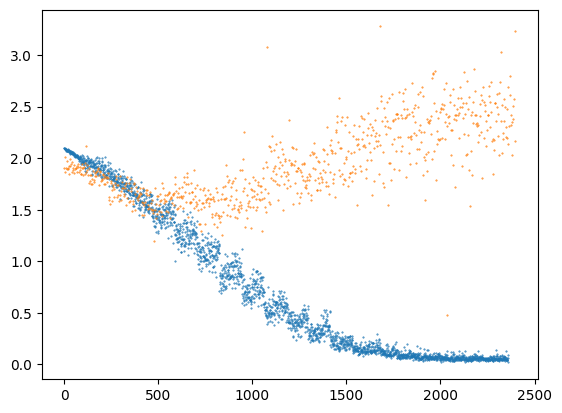

In [222]:
import matplotlib.pyplot as plt

# Save and plot losses
torch.save(train_losses,f="train_losses_model_2.pt")
torch.save(val_losses,f="val_losses_model_2.pt")

t1 = np.arange(len(train_losses))
t2 = train_size/val_size*np.arange(len(val_losses))
plt.scatter(t1,train_losses,s=0.2)
plt.scatter(t2,val_losses,s=0.2)
plt.show()

<p>Evaluate.</p>

In [223]:
speech_classifier.eval()
y_tests = np.array([])
y_preds = np.array([])
for i, ((X_test, X_lengths), y_test) in enumerate(test_loader):
    y_pred = speech_classifier(X_test).softmax(dim=1).argmax(dim=1)
    y_tests = np.concatenate((y_tests,y_test))
    y_preds = np.concatenate((y_preds,y_pred))
print(i)

4


In [224]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_tests,y_preds,target_names=possible_parties))

              precision    recall  f1-score   support

           S       0.56      0.56      0.56      1610
          SD       0.45      0.41      0.43       629
           M       0.36      0.41      0.38       871
           V       0.39      0.37      0.38       396
           C       0.34      0.36      0.35       342
          MP       0.33      0.21      0.26       565
          KD       0.26      0.31      0.28       353
           L       0.27      0.34      0.30       234

    accuracy                           0.42      5000
   macro avg       0.37      0.37      0.37      5000
weighted avg       0.42      0.42      0.42      5000

